In [2]:
import networkx as nx
import shapely
import shapely.geometry
import pyproj
import itertools

from datetime import datetime, timedelta
import time
import simpy
import openclsim.core as core
import openclsim.model as model
import openclsim.plugins as plugin
import openclsim.plot as plot

import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import folium
import sys
import os

## Import the estimating modules

In [3]:
sys.path.insert(0, os.path.join((os.getcwd()), 'src','WID', 'Parameters'))
import dj_WID

sys.path.insert(0, os.path.join((os.getcwd()), 'src', 'WID', 'Production'))
from WID_Production import WID_production

sys.path.insert(0, os.path.join((os.getcwd()), 'src', 'WID', 'Propeller'))
from WID_calculate_power import *
from Suction_pipe_forces import * 

sys.path.insert(0, os.path.join((os.getcwd()), 'src', 'WID', 'Pump'))
from Testing_pump_module import *

## Tidal functions needed for Tidal Plugin

In [3]:
def tidal_level(t, tidal_amplitude):
    tidal_period = 12.42

    phi= -0.35
    water_level = (tidal_amplitude / 2) * np.sin(2 * np.pi * t / tidal_period - phi)        ## Waterlevel calculation
    return water_level

def tidal_direction(t, tidal_amplitude):
    tidal_period = 12.42
    phi = -0.35
    
    water_direction = (np.pi * tidal_amplitude / tidal_period) * np.cos(2 * np.pi * t / tidal_period - phi) 
    return water_direction

def Delay_DredgingTime(t_now, tidal_amplitude):
    tidal_period = 12.42 
    t_end = t_now + tidal_period
    t_start = t_now - tidal_period
    t = np.arange(t_start, t_end, 1/60)                
    
    water_dir_values = tidal_direction(t, tidal_amplitude)

    start_outgoing = (np.where((np.diff(np.sign(water_dir_values)) < 0))[0])
    end_outgoing = (np.where((np.diff(np.sign(water_dir_values)) > 0))[0]) 
    time_start_outgoing = t[start_outgoing]
    time_end_outgoing = t[end_outgoing]
    
    for i in range(len(time_start_outgoing)):   ## Eliminating all negative values: 0 means already passed
        if time_start_outgoing[i] < 0:
            time_start_outgoing[i] = 0
            
        if time_end_outgoing[i] < 0:
            time_end_outgoing[i] = 0

    tidal_direction_now = tidal_direction(t_now, tidal_amplitude)

    if tidal_direction_now > 0:
        delay = time_start_outgoing[1] - t_now
        dredging_time_left = 0
    else:
        delay = 0
        dredging_time_left = time_end_outgoing[1] - t_now

    return delay, dredging_time_left

def AmountDredgingLeft(t_now):
    dredging_time_left = Delay_DredgingTime(t_now)[1]
    dredging_production = WID_production.Density_Based_Production_WID()['Q_dredged']  ## In m3/hr

    amount_dredging_left = dredging_time_left * dredging_production           ##m3 untill start high water
    
    return amount_dredging_left

## Define the constants 

In [4]:
tidal_amplitude = dj_WID.Production['A_tidal']
operational_factor = dj_WID.Project['operational_factor']
dredging_volume = dj_WID.Production['V_dredged']
production = WID_production.Factor_Based_Production_WID()['Q_dredged'] / 3600 * operational_factor    ## m3/hr dredging production to m3/s
RamsgateDistance = dj_WID.Project["Ramsgate_distance"]
V_port_sailing = 2                                                               ## m/s
V_sea_sailing = 3.1                                                              ## m/s
V_dredging = 0.51444                                                             ## Conversion from knots to m/s
distance_Site_Port = 405                                                         ## Distance from site to port [m]
tidal_amplitude = dj_WID.Production["A_tidal"]
h_sea = 22                                                                       ## mean water depth at sea
h_port = dj_WID.Project["z"]                                                     ## mean water depth at port
alpha_board = dj_WID.Vessel["alpha_board"]
P_board_installed = dj_WID.Vessel["P_board_installed"]
alpha_thruster = dj_WID.Vessel["alpha_thruster"]
P_thruster_installed = dj_WID.Vessel["P_thruster_installed"]
sailing_duration = distance_Site_Port / V_port_sailing
tidal_period_sec = 12.42 * 3600                                                  ## tidal period in seconds
producing_duration = (tidal_period_sec / 2) - sailing_duration
producing_amount = producing_duration * production                               ## Total amount produce during 1 session in m3, 80% is WID
F_d_jet_system = (Forces_jet_system_dynamic(V_dredging)['F_d_vessel'] / 1000)    ## Convert to kN
total_dredging_time = dredging_volume/(production*3600)

## Classes for the Energy Plugin

In [5]:
class HasEnergyPlugin:
    """Mixin for Activity to initialize Power for dredging activities."""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        energy_plugin = EnergyPlugin()
        self.register_plugin(plugin=energy_plugin, priority=3)

class EnergyPlugin(model.AbstractPluginClass):
    """Mixin for all activities to add delay and downtime."""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def post_process(
        self, env, activity_log, activity, start_activity, start_preprocessing, *args, **kwargs
    ):
        if activity.name == 'sea_trip':
            power_prop = WID_calculate_power(V_0 = V_sea_sailing, h = h_sea)[6] 
            power_jet = None
            power_bow_thrusters = None
            power_board_net = alpha_board * P_board_installed 
            activity_duration = env.now - start_activity

        if activity.name == 'dredging_trip':
            power_prop = WID_calculate_power(V_0 = V_port_sailing, h=h_port)[6]
            power_jet = None
            power_bow_thrusters = alpha_thruster * P_thruster_installed
            power_board_net = alpha_board * P_board_installed
            activity_duration = env.now - start_activity
            
        if activity.name == 'dredging':
            power_prop = WID_calculate_power(V_0 = V_dredging, h = h_port, R_jet_system=F_d_jet_system)[6] 
            power_jet = pump_power()[0]["P"].item() * 2
            power_bow_thrusters = alpha_thruster * P_thruster_installed
            power_board_net = alpha_board * P_board_installed
            activity_duration = env.now - start_activity

        if activity.name == 'port_trip':
            power_prop = WID_calculate_power(V_0 = V_port_sailing, h=h_port)[6] 
            power_jet = None
            power_bow_thrusters = alpha_thruster * P_thruster_installed
            power_board_net = alpha_board * P_board_installed
            activity_duration = env.now - start_activity

        if activity.name == 'preparing':
            power_prop = None
            power_jet = None
            power_bow_thrusters = None
            power_board_net = alpha_board * P_board_installed
            activity_duration = env.now - start_preprocessing
        
        activity.log_entry_v1(
            t=env.now,
            activity_id=activity.id,
            activity_state=core.LogState.UNKNOWN,
            additional_state={
                "propulsion": power_prop,
                "jet": power_jet,
                "bow_thrusters": power_bow_thrusters,
                "board_net": power_board_net,
                "activity_duration": activity_duration,
            }
        )
        return {}

## Classes for the Tidal Plugin

In [6]:
class HasTidalPlugin:
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        TidalAccess = TidalAccessPlugin()
        self.register_plugin(plugin=TidalAccess, priority=3)

class TidalAccessPlugin(model.AbstractPluginClass):
    "Mixin for activities which depend on tidal direction"
    def __init__(
        self,
        tidal_amplitude=dj_WID.Production['A_tidal'] / 2,
        tidal_period=12.42,
        *args,
        **kwargs
    ):
        super().__init__(*args, **kwargs)
    def pre_process(
        self, env, activity_log, activity, *args, **kwargs
    ):
        t_hours = env.now / 3600     ## Convert simulating time units to seconds

        delay = Delay_DredgingTime(t_hours, tidal_amplitude)[0]
        delay_sec = delay * 3600
        time_left_to_dredge = Delay_DredgingTime(t_hours, tidal_amplitude)[1]   ## Time left until outgoing tide stops, Equals zero
        tide_direction = tidal_direction(t_hours, tidal_amplitude)        ## Direction of the tide
        
        if activity.name == "preparing":
            if tide_direction > 0:
                #print(f'Tide direction : {tide_direction} at time: {t_hours}. Wait for: {delay_sec / 3600} hours')
                activity_label = {
                    "type": "plugin",
                    "ref": "Waiting on the tide",
                }
                return activity.delay_processing(env, activity_label, activity_log, delay_sec)
            else:            
                return {}

        activity.log_entry_v1(
            t=env.now,
            activity_id = activity.id,
            activity_state = core.LogState.UNKNOWN,
            additional_state={
            }
        )
        return {}

## Initialize simulation

In [7]:
simulation_start_date = datetime(2024, 6, 16, 6, 30)
simulation_start = simulation_start_date.timestamp()
my_env = simpy.Environment(initial_time=simulation_start)

In [8]:
DredgingSite = type(
    "DredgingSite",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

TransportingProcessingResource = type(
    "TransportProcessResource",
    (
        core.ContainerDependentMovable,      
        core.Movable,
        core.HasResource,
        core.WIDProcessor,
        core.Identifiable,
        core.Log,
    ),
    {},
)

## Initialize location and vessel

In [9]:
location_origin = shapely.geometry.Point(4.057305, 51.965713)
location_port = shapely.geometry.Point(1.41941, 51.32966)
location_dredging = shapely.geometry.Point(1.420900, 51.325379)

data_origin = {
    "env": my_env,
    "name": "origin_vessel",
    "geometry": location_origin,
    "capacity": 0,
}

data_port = {
    "env": my_env,
    "name": "port",
    "geometry": location_port,  
    "capacity": 1000,
}

data_dredging_site = {
    "env": my_env,
    "name": "dredging site",
    "geometry": location_dredging,
    "capacity": dredging_volume,
    "level": dredging_volume,    
}

Origin_Site = Site(**data_origin)
Port_Site = Site(**data_port)
Dredging_Site = DredgingSite(**data_dredging_site)

data_dredging_vessel = {
    "env": my_env,
    "name": "dredging vessel",
    "geometry": location_port,
    "capacity": 25000 * 12,        ## Capacity does not matter, but should be more than production rate!
    "compute_v": V_port_sailing,    
}

WID_vessel = TransportingProcessingResource(**data_dredging_vessel)

In [10]:
registry = {}
keepresources ={}

## Define activities

In [11]:
EnergyMoveActivity = type(        ## DREDGING TRIP, PORT TRIP
    "MovingActivity",
    (
        HasEnergyPlugin,
        model.MoveActivity,      
    ),
    {},
)

EnergyBasicActivity = type(     ## WAITING IN BERTH LOCATION
    "BasicActivity",
    (
        HasEnergyPlugin,
        model.BasicActivity,
    ),
    {},
)

TidalBasicActivity = type(      ## PREPARING
    "TidalActivity", 
    (
        HasTidalPlugin,
        HasEnergyPlugin,
        model.BasicActivity,

    ),
    {},
)

EnergyProducingAmountActivity = type(  ## DREDGING
    "ProduceActivtiy",
    (
        HasEnergyPlugin,
        model.ProduceAmountActivity,
    ),
    {},
)

In [12]:
sub_processes = [
    TidalBasicActivity(
        env=my_env,
        name="preparing",
        registry=registry,
        duration = 20,
    ),
    EnergyMoveActivity(
        env=my_env,
        name='dredging_trip',
        registry=registry,
        mover = WID_vessel,
        destination = Dredging_Site,
        duration = sailing_duration,
    ),

    EnergyProducingAmountActivity(
        env=my_env,
        name="dredging",
        duration = producing_duration,
        registry=registry,
        WIDprocessor = WID_vessel,
        destination = WID_vessel,
        origin = Dredging_Site,
        amount = producing_amount ,
        start_event = [{
            "type": "activity",
            "name": "preparing",
            "state": "done"
        }],
    ),
    EnergyMoveActivity(
        env=my_env,
        name="port_trip",
        registry=registry,
        mover=WID_vessel,
        destination=Port_Site,
        duration= sailing_duration,
        start_event = [{
            "type":"activity",
            "name":"dredging",
            "state":"done",
        }],
    ),    
]

In [13]:
sequential_activity = model.SequentialActivity(
    env=my_env,
    registry=registry,
    name="Sequence",
    sub_processes = sub_processes
)

while_activity = model.WhileActivity(
    env=my_env,
    registry=registry,
    name="While",
    sub_processes= [sequential_activity],
    condition_event=[{
        "type":"container",
        "concept": Dredging_Site,
        "state": "empty",
    }]
)

## Start simulation

In [14]:
model.register_processes(while_activity)
my_env.run()

### Retrieve simulation data:

In [25]:
df_site = plot.get_log_dataframe(Dredging_Site, [while_activity, sequential_activity, *sub_processes])

df_WID = pd.concat(
    plot.get_log_dataframe(act, [while_activity, sequential_activity, *sub_processes])
    for act in [while_activity, *sub_processes]
).sort_values(by=["Timestamp", "Activity"], ascending=[True, False])

df_WID = df_WID[df_WID["ActivityState"] == "UNKNOWN"].copy()
df_WID.fillna(0, inplace=True)
df_WID.loc[:, "energy"] = (df_WID["propulsion"] + df_WID["jet"] + df_WID["bow_thrusters"] + df_WID["board_net"]) * (df_WID["activity_duration"]) / 1000000
df_WID["cum sum"] = df_WID["energy"].cumsum()

### Visualization

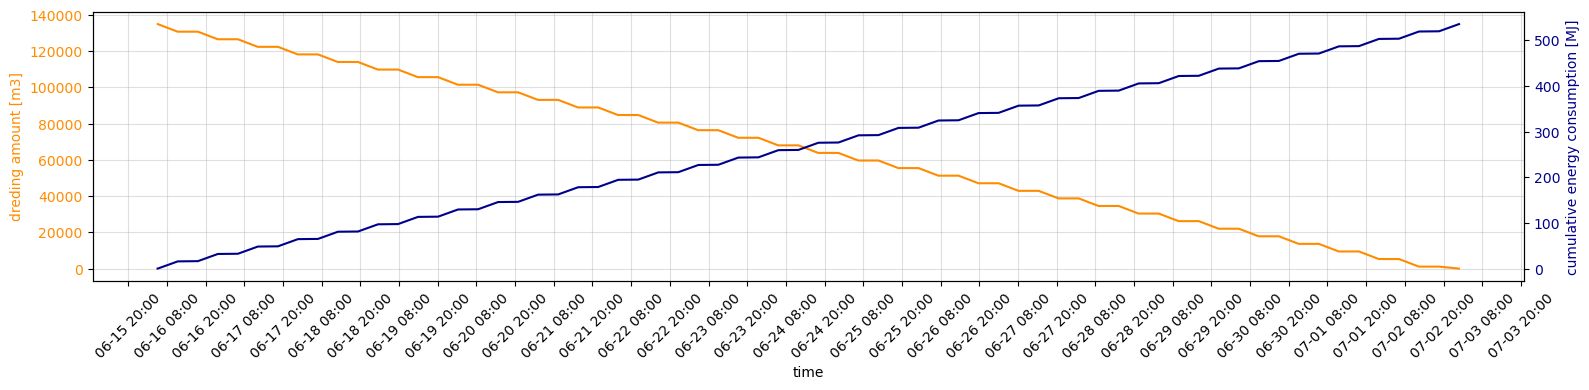

In [27]:
fig1, ax1 = plt.subplots(figsize=(16,4))

ax1.plot(df_site["Timestamp"], df_site["container level"], color="darkorange")
ax1.set_ylabel('dreding amount [m3]', color='darkorange')
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=12))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
ax1.set_xlabel('time')
ax1.tick_params(axis='y', labelcolor='darkorange')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.4)

ax2 = ax1.twinx()
ax2.plot(df_WID["Timestamp"], df_WID["cum sum"], color="darkblue")
ax2.set_xlabel('Time')
ax2.set_ylabel('cumulative energy consumption [MJ]', color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')
ax2.tick_params(axis='x', rotation=45)
ax2.set_title(f'')

fig1.tight_layout()

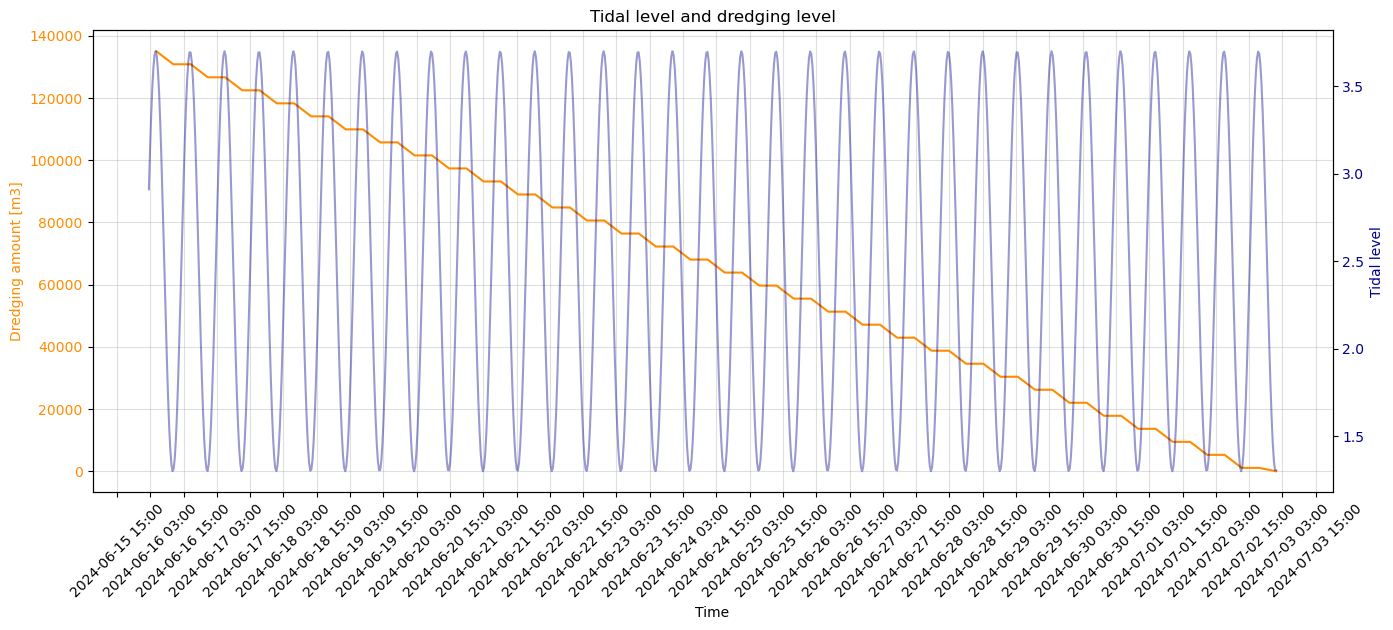

In [28]:
t_start = datetime(2024, 6, 16, 2, 30)
timestamp_end = df_site['Timestamp'].iloc[-1]
t_end = pd.to_datetime(timestamp_end)
time = pd.date_range(start=t_start, end=t_end, periods=1000)
t_time = np.linspace(0, (t_end - t_start).total_seconds() / 3600, len(time))

wl_time = tidal_level(t_time, tidal_amplitude) + 2.5

fig, ax1 = plt.subplots(figsize=(16,6))
ax1.set_title('Tidal level and dredging level')
ax1.plot(df_site['Timestamp'], df_site['container level'], label='Remaining dredging amount', color='darkorange')
ax1.set_xlabel('Time')
ax1.set_ylabel('Dredging amount [m3]', color='darkorange')
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=12))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
#ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
#ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
ax1.tick_params(axis='y', labelcolor='darkorange')
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(time, wl_time, label='Tidal level', color='darkblue', alpha=0.4)
ax2.tick_params(axis='y', labelcolor='darkblue')
ax2.set_ylabel('Tidal level', color="darkblue")

ax1.grid(alpha=0.4);